In [1]:

# STEP 1: import libries and dataset


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Load Final Preprocessed Dataset
final_path = '/content/drive/My Drive/results/final_preprocessed_dataset.csv'
final_df = pd.read_csv(final_path)
print("Loaded final preprocessed dataset:", final_df.shape)


Mounted at /content/drive
Loaded final preprocessed dataset: (6295, 11)


In [10]:

# STEP 2: Split Dataset into Train and Test

from sklearn.model_selection import train_test_split
# Separate Features (X) and Target (y)

X = final_df.drop(columns=["Target"])   # All independent variables
y = final_df["Target"]                  # Dependent variable (Target: Dropout / Graduate / Enrolled)

# 80% Training Data & 20% Testing Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,          # 20% for testing
    random_state=42,
    stratify=y
)
# Display Dataset Shapes

print("Dataset successfully split!")
print("• Training Set Shape :", X_train.shape)
print("• Testing Set Shape  :", X_test.shape)

# show class balance before and after split
print("\nClass Distribution in Training Set:")
print(y_train.value_counts())

print("\nClass Distribution in Testing Set:")
print(y_test.value_counts())

✅ Dataset successfully split!
• Training Set Shape : (5036, 10)
• Testing Set Shape  : (1259, 10)

Class Distribution in Training Set:
Target
1    1724
2    1668
0    1644
Name: count, dtype: int64

Class Distribution in Testing Set:
Target
1    431
2    417
0    411
Name: count, dtype: int64


In [17]:

# STEP 3: Define Base SVM Model & Hyperparameter Grid

from sklearn.svm import SVC

# SVM = Support Vector Machine — a strong classifier for nonlinear and high-dimensional data.
svm_model = SVC(random_state=42)
# Define Hyperparameter Grid for Optimization
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
# Display Parameter Grid
print("Base SVM Model and Hyperparameter Grid defined successfully.")
print("\nHyperparameter Grid:")
for param, values in param_grid.items():
    print(f"• {param} : {values}")


Base SVM Model and Hyperparameter Grid defined successfully.

Hyperparameter Grid:
• C : [0.1, 1, 10]
• kernel : ['linear', 'rbf', 'poly']
• gamma : ['scale', 'auto']


In [18]:

# STEP 4 : Perform GridSearchCV for Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
print("\nBest Parameters Found:", grid_search.best_params_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best Parameters Found: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [33]:

# STEP 5: Evaluate the Best SVM Model

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
best_svm = grid_search.best_estimator_

# Predict on Test Data-
y_pred = best_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Map numeric target values to readable labels
class_labels = ['Dropout', 'Graduate', 'Enrolled']
# If target is numeric, map to class names
if y_test.dtype != 'O':
    y_test_named = y_test.map({0: 'Dropout', 1: 'Graduate', 2: 'Enrolled'})
    y_pred_named = pd.Series(y_pred).map({0: 'Dropout', 1: 'Graduate', 2: 'Enrolled'})
else:
    y_test_named = y_test
    y_pred_named = pd.Series(y_pred)
print("\Test Accuracy:", round(accuracy, 4))

# Print Classification Report

print("\nClassification Report:")
print(classification_report(y_test_named, y_pred_named, target_names=class_labels))





\Test Accuracy: 0.7681

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.82      0.72      0.76       411
    Graduate       0.79      0.84      0.81       417
    Enrolled       0.70      0.75      0.73       431

    accuracy                           0.77      1259
   macro avg       0.77      0.77      0.77      1259
weighted avg       0.77      0.77      0.77      1259



<>:20: SyntaxWarning: invalid escape sequence '\T'
<>:20: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-3360663244.py:20: SyntaxWarning: invalid escape sequence '\T'
  print("\Test Accuracy:", round(accuracy, 4))


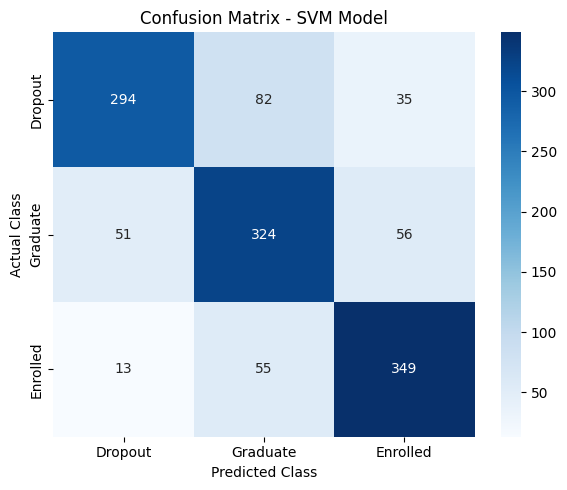

In [23]:
# STEP 6: Confusion Matrix Visualization

# Define class labels
class_labels = ['Dropout', 'Graduate', 'Enrolled']
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix heatmap
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title('Confusion Matrix - SVM Model')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
# Create results folder if it doesn't exist
os.makedirs('/content/drive/My Drive/results/', exist_ok=True)
# Save figure as PNG
plt.savefig('/content/drive/My Drive/results/svm_confusion_matrix_named.png', bbox_inches='tight')
plt.show()


In [34]:

# STEP 7: Save model perfermonce

from sklearn.model_selection import cross_val_score

# Calculate cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

results_summary = {
    "Best Parameters": [grid_search.best_params_],
    "Test Accuracy": [accuracy],
    "CV Mean Accuracy": [cv_scores.mean()],
    "CV Std Dev": [cv_scores.std()]
}

results_df = pd.DataFrame(results_summary)
results_df.to_csv('/content/drive/My Drive/results/svm_results_summary.csv', index=False)
print("\nSVM results saved to: /content/drive/My Drive/results/svm_results_summary.csv")


SVM results saved to: /content/drive/My Drive/results/svm_results_summary.csv


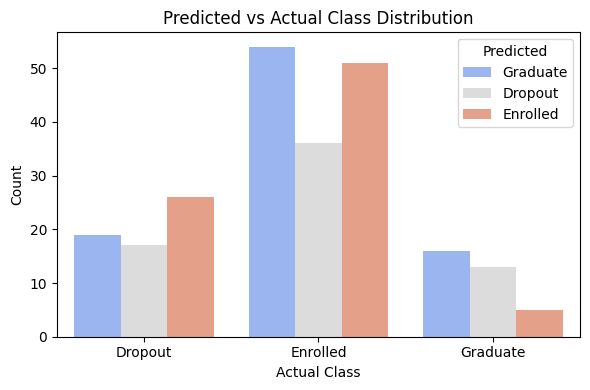

In [35]:

# Predicted vs Actual Class Distribution


plt.figure(figsize=(6,4))
sns.countplot(x=y_test_named, hue=y_pred_named, palette='coolwarm')
plt.title('Predicted vs Actual Class Distribution')
plt.xlabel('Actual Class')
plt.ylabel('Count')
plt.legend(title='Predicted')
plt.tight_layout()
plt.savefig('/content/drive/My Drive/results/svm_pred_vs_actual_named.png', bbox_inches='tight')
plt.show()
